## HistGradientBoosting Regressor

Saved predicted Helsinki hex CO2 to helsinki_hex_predicted_car_co2_tree.csv


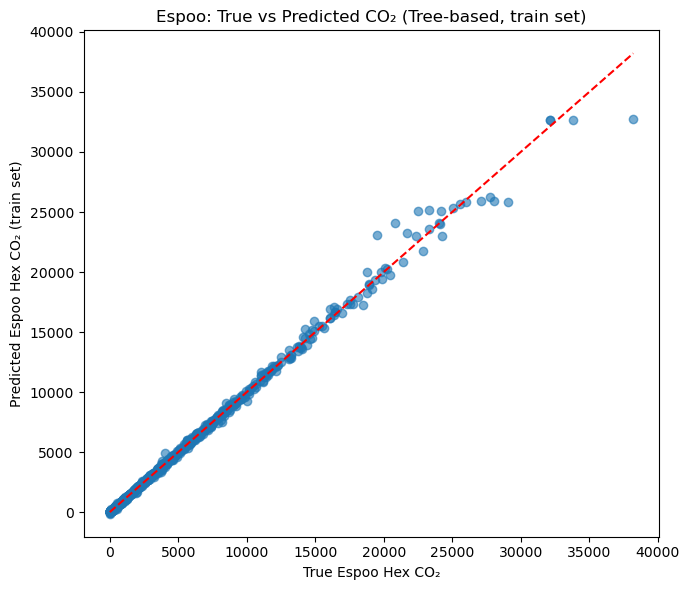


Test set size: 1208
MSE: 716255.4043380086
R^2: 0.9621335126000538


In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Load data
df_trip = pd.read_csv("locomizer_data_complete.csv")
df_hex = pd.read_csv("hex_attributes_combined.csv")
df_trip['one'] = 1

# 2. Aggregate per origin hexagon
agg_funcs = {
    'car_co2_locomizer': 'sum',
    'car_dist': 'sum',
    'car_time': 'sum',
    'shortest_distance_m': 'sum',
    'one': 'sum'
}
grouped = (
    df_trip
    .groupby('ORIGIN_CODE9')
    .agg(agg_funcs)
    .rename(columns={
        'car_co2_locomizer': 'total_car_co2',
        'car_dist': 'total_car_dist',
        'car_time': 'total_car_time',
        'shortest_distance_m': 'total_shortest_dist',
        'one': 'no_of_trips'
    })
    .reset_index()
    .rename(columns={'ORIGIN_CODE9': 'hex_id'})
)

# 3. Merge static attributes from df_hex
merged = grouped.merge(df_hex, on='hex_id', how='left')

# 4. Attach municipality info
if 'ORIGIN_Municipality' in df_trip.columns:
    muni = df_trip[['ORIGIN_CODE9', 'ORIGIN_Municipality']].drop_duplicates().rename(
        columns={'ORIGIN_CODE9': 'hex_id'}
    )
    merged = merged.merge(muni, on='hex_id', how='left')

# 5. Split by municipality
train = merged[merged['ORIGIN_Municipality'].str.lower() == 'espoo'].copy()
test = merged[merged['ORIGIN_Municipality'].str.lower() == 'helsinki'].copy()

# 6. Features for ML
features = [
    'population', 'avg_speed', 'n_traffic_signals', 'total_built_area', 'stop_count',
    'total_car_dist', 'total_car_time', 'total_shortest_dist', 'no_of_trips'
]
target = 'total_car_co2'

train = train.dropna(subset=features + [target])
test = test.dropna(subset=features)

X_train = train[features].values
y_train = train[target].values
X_test = test[features].values
y_test = test[target].values

# 7. Train and predict with tree-based model
tree = HistGradientBoostingRegressor(max_iter=200, random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
test['predicted_car_co2'] = y_pred

# 8. Save results
test[['hex_id', 'predicted_car_co2','total_car_co2'] + features].to_csv('helsinki_hex_predicted_car_co2_tree.csv', index=False)
print("Saved predicted Helsinki hex CO2 to helsinki_hex_predicted_car_co2_tree.csv")

# 9. Plot true vs predicted for Espoo (train set)
y_train_pred = tree.predict(X_train)
plt.figure(figsize=(7,6))
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.xlabel("True Espoo Hex CO₂")
plt.ylabel("Predicted Espoo Hex CO₂ (train set)")
plt.title("Espoo: True vs Predicted CO₂ (Tree-based, train set)")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.tight_layout()
plt.show()


# 11. Print test set metrics
print(f"\nTest set size: {len(y_pred)}")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))



Tree-based model permutation importances:
total_car_dist      : 1.171
total_shortest_dist : 0.124
total_car_time      : 0.001
avg_speed           : 0.001
stop_count          : 0.000
n_traffic_signals   : -0.000
total_built_area    : -0.002
no_of_trips         : -0.006
population          : -0.016


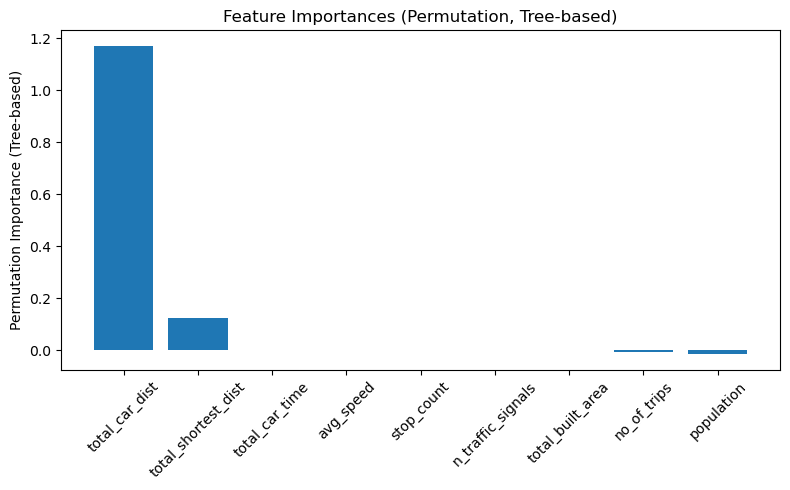

In [2]:
from sklearn.inspection import permutation_importance



# --- 10. Feature importances with permutation_importance ---
result = permutation_importance(tree, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances = result.importances_mean
sorted_idx = np.argsort(importances)[::-1]

print("\nTree-based model permutation importances:")
for idx in sorted_idx:
    print(f"{features[idx]:20s}: {importances[idx]:.3f}")

plt.figure(figsize=(8,5))
plt.bar([features[i] for i in sorted_idx], importances[sorted_idx])
plt.xticks(rotation=45)
plt.ylabel("Permutation Importance (Tree-based)")
plt.title("Feature Importances (Permutation, Tree-based)")
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import geopandas as gpd

# Load predictions and ground truth
df = pd.read_csv('helsinki_hex_predicted_car_co2_tree.csv')  # or your output file
# If you have true values in another column, make sure it's included

# Load hex polygons
hexes = gpd.read_file("h3_polygons_Helsinki.gpkg")
hexes['hex_id'] = hexes['ID'].astype(str)  # Adjust if your hex ID column is different


In [4]:
# Merge predictions into hex polygons
merged = hexes.merge(df, on='hex_id', how='left')


In [7]:
print(merged.columns)


Index(['ID', 'geometry', 'hex_id', 'predicted_car_co2', 'population',
       'avg_speed', 'n_traffic_signals', 'total_built_area', 'stop_count',
       'total_car_dist', 'total_car_time', 'total_shortest_dist',
       'no_of_trips'],
      dtype='object')


In [7]:
import folium

# Center map on Helsinki (or the mean of your hexes)
centroid = merged.geometry.unary_union.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=11, tiles='cartodbpositron')

# --- Add predicted CO2 as colored polygons ---
import branca.colormap as cm

# Define a colormap for predicted values
pred_min = merged['predicted_car_co2'].min()
pred_max = merged['predicted_car_co2'].max()
colormap = cm.linear.YlOrRd_09.scale(pred_min, pred_max)

for _, row in merged.iterrows():
    if pd.notnull(row['predicted_car_co2']):
        folium.GeoJson(
            row.geometry,
            style_function=lambda feature, value=row['predicted_car_co2']:
                {'fillColor': colormap(value), 'color': 'black', 'weight': 0.2, 'fillOpacity': 0.8},
            tooltip=folium.Tooltip(f"Hex: {row['hex_id']}<br>Predicted CO₂: {row['predicted_car_co2']:.0f}"),
        ).add_to(m)

colormap.caption = "Predicted Car CO₂"
colormap.add_to(m)


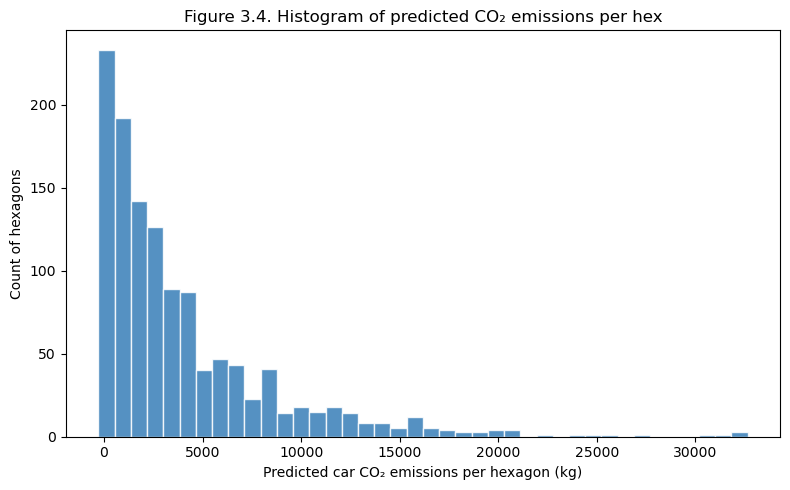

In [8]:
import matplotlib.pyplot as plt

co2_vals = merged['predicted_car_co2'].dropna()

plt.figure(figsize=(8, 5))
plt.hist(co2_vals, bins=40, color='#377eb8', edgecolor='white', alpha=0.85)
plt.xlabel("Predicted car CO₂ emissions per hexagon (kg)")
plt.ylabel("Count of hexagons")
plt.title("Figure 3.4. Histogram of predicted CO₂ emissions per hex")
plt.tight_layout()
plt.show()


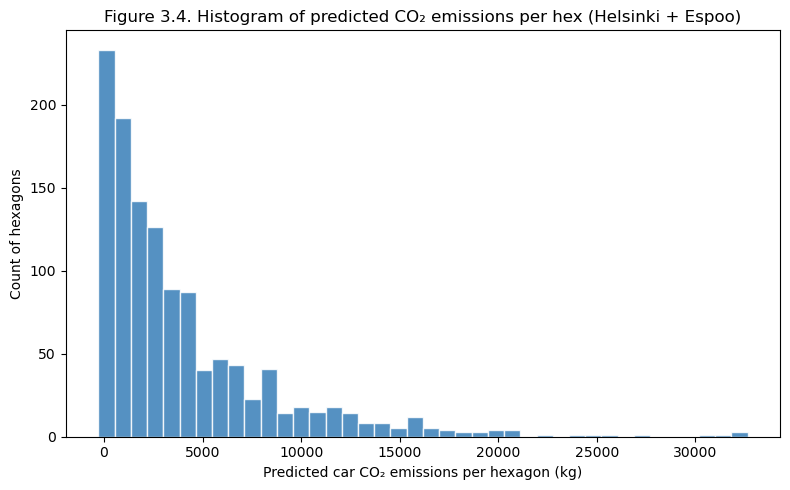

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(merged['predicted_car_co2'].dropna(), bins=40, color='#377eb8', edgecolor='white', alpha=0.85)
plt.xlabel("Predicted car CO₂ emissions per hexagon (kg)")
plt.ylabel("Count of hexagons")
plt.title("Figure 3.4. Histogram of predicted CO₂ emissions per hex (Helsinki + Espoo)")
plt.tight_layout()
plt.show()


In [11]:
import folium
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import matplotlib

# --- 1. Prepare Data ---
# merged = gpd.read_file("...")  # You already have the GeoDataFrame with geometry and predicted_car_co2

co2_col = "predicted_car_co2"   # or 'total_car_co2'
min_co2 = merged[co2_col].min()
max_co2 = merged[co2_col].max()

# Color map
norm = matplotlib.colors.Normalize(vmin=min_co2, vmax=max_co2)
cmap = plt.cm.OrRd

def get_color(val):
    if pd.isnull(val):
        return "#dddddd"
    rgba = cmap(norm(val))
    return matplotlib.colors.rgb2hex(rgba)

merged['color'] = merged[co2_col].apply(get_color)

# Center map
mean_lat = merged.geometry.centroid.y.mean()
mean_lon = merged.geometry.centroid.x.mean()
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=11, tiles='cartodbpositron')

# --- 2. Add H3 Polygons ---
for _, row in merged.iterrows():
    folium.GeoJson(
        row.geometry.__geo_interface__,
        style_function=lambda x, col=row['color']: {
            'fillColor': col,
            'color': '#333',
            'weight': 0.3,
            'fillOpacity': 0.82,
        },
        highlight_function=lambda x: {'weight':2, 'color':'#000'},
        tooltip=folium.Tooltip(f"CO₂: {row[co2_col]:,.1f} kg" if pd.notnull(row[co2_col]) else "No data")
    ).add_to(m)

# --- 3. Add Title ---
title_html = """
<div style="background:white; border-radius:10px; margin:auto; width:60%; border:2.5px solid #C0392B; margin-top:8px; margin-bottom:20px;">
    <h3 style="color:#C0392B; text-align:center; font-size:22px; font-weight:bold; margin:10px 0;">
        Figure 3.5. Map of total CO₂ emissions per hex
    </h3>
</div>
"""
m.get_root().html.add_child(folium.Element(title_html))

# --- 4. Add Legend ---
legend_html = f"""
<div style="
    position: fixed;
    bottom: 35px; left: 20px; width: 270px; height: 60px;
    background: white;
    border:2px solid #333;
    z-index:9999;
    font-size:14px;
    box-shadow: 0 2px 10px rgba(0,0,0,0.07);
    border-radius: 10px;
    padding: 7px 15px 7px 15px;">
    <div style="font-weight:bold; color:#C0392B; margin-bottom:2px;">CO₂ Emissions per Hex (kg)</div>
    <div style="display:flex; align-items:center;">
        <span style="margin-right:7px;">{min_co2:,.1f}</span>
        <div style="
            background: linear-gradient(to right, {matplotlib.colors.rgb2hex(cmap(0.0))}, {matplotlib.colors.rgb2hex(cmap(0.25))}, {matplotlib.colors.rgb2hex(cmap(0.5))}, {matplotlib.colors.rgb2hex(cmap(0.75))}, {matplotlib.colors.rgb2hex(cmap(1.0))});
            height: 18px;
            flex:1 1 auto;
            margin: 0 7px;
            border-radius: 6px;">
        </div>
        <span style="margin-left:7px;">{max_co2:,.1f}</span>
    </div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# --- 5. Save ---
m.save("figure_3_5_hex_co2_map_with_legend.html")
print("Map saved as figure_3_5_hex_co2_map_with_legend.html")


/run/nvme/job_28744248/tmp/ipykernel_3259383/2859054304.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mean_lat = merged.geometry.centroid.y.mean()
/run/nvme/job_28744248/tmp/ipykernel_3259383/2859054304.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mean_lon = merged.geometry.centroid.x.mean()


Map saved as figure_3_5_hex_co2_map_with_legend.html


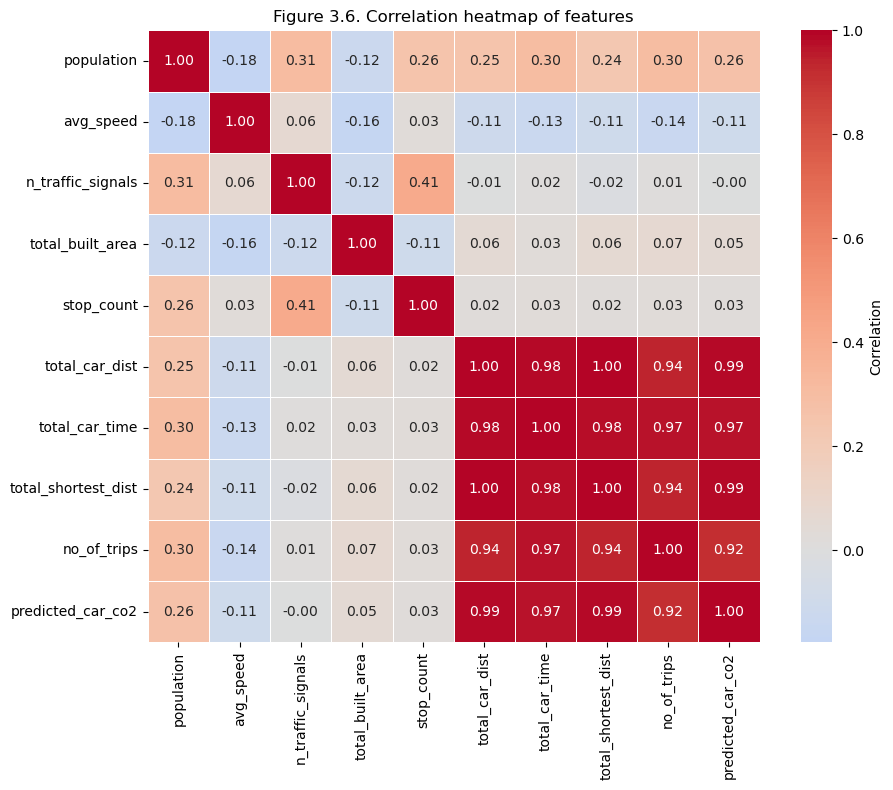

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataframe, e.g.:
# merged = pd.read_csv("your_final_hex_level_data.csv") 
# or if it's a GeoDataFrame, just use merged as before

# Select only numerical columns you want to check correlations for
corr_cols = [
    'population', 'avg_speed', 'n_traffic_signals', 'total_built_area', 'stop_count',
    'total_car_dist', 'total_car_time', 'total_shortest_dist', 'no_of_trips', 'predicted_car_co2'
    # or 'total_car_co2' if you want true values
]

# Drop rows with missing values (optional, but helps with heatmap)
corr_data = merged[corr_cols].dropna()

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f", square=True, linewidths=.7, cbar_kws={'label': 'Correlation'})
plt.title("Figure 3.6. Correlation heatmap of features")
plt.tight_layout()
plt.savefig("figure_3_6_correlation_heatmap.png", dpi=200)
plt.show()


In [ ]:
from graphviz import Digraph

dot = Digraph(comment='Data workflow and feature engineering pipeline', format='png')
dot.attr(rankdir='LR', size='8,5')

# Data Sources
dot.node('A', 'Locomizer OD Trips\n(origin-destination data)', shape='box', style='filled', fillcolor='#e6f2ff')
dot.node('B', 'Population & Built Area\n(Statistics Finland Ruututietokanta)', shape='box', style='filled', fillcolor='#e6f2ff')
dot.node('C', 'Speed, Stops, Traffic Signals\n(HSL GTFS & Open Data)', shape='box', style='filled', fillcolor='#e6f2ff')
dot.node('D', 'Municipality Boundaries\n(Official Shapefiles)', shape='box', style='filled', fillcolor='#e6f2ff')

# Processing steps
dot.node('E', 'Map Trip Origins/Dests to\nH3 Hexagons (Res 8)', shape='ellipse', style='filled', fillcolor='#f2f2f2')
dot.node('F', 'Aggregate Trip Data to Hexagon\nLevel (CO₂, distance, time, trips)', shape='ellipse', style='filled', fillcolor='#f2f2f2')
dot.node('G', 'Merge Static & Dynamic Features\nfor Each Hexagon', shape='ellipse', style='filled', fillcolor='#f2f2f2')
dot.node('H', 'Assign Municipality to Hexagons\n(spatial overlay & validation)', shape='ellipse', style='filled', fillcolor='#f2f2f2')
dot.node('I', 'Screen for Missing/Implausible/Outlier Values', shape='ellipse', style='filled', fillcolor='#f2f2f2')

# Final dataset
dot.node('J', 'Final Hexagon Feature Table\n(spatially aligned, clean)', shape='box', style='filled', fillcolor='#b3e6b3')

# Connections
dot.edges(['AE', 'BE', 'CE'])
dot.edge('E', 'F')
dot.edge('F', 'G')
dot.edge('D', 'H')
dot.edge('G', 'H')
dot.edge('H', 'I')
dot.edge('I', 'J')
print(dot.source)
# Save and/or render
dot.render('figure_4_1_data_workflow', view=True)  # Saves as figure_4_1_data_workflow.png

print("Flowchart saved as 'figure_4_1_data_workflow.png'.")


In [15]:
from graphviz import Digraph

dot = Digraph('Model Training Pipeline', format='png')
dot.attr(rankdir='LR', size='10,5')

# 1. Input data
dot.node('A', 'Espoo Hexagon Feature Table\n(with CO₂ ground truth)', shape='box', style='filled', fillcolor='#e6f2ff')
dot.node('B', 'Helsinki Hexagon Feature Table\n(no target, for testing)', shape='box', style='filled', fillcolor='#e6f2ff')

# 2. Model training block
dot.node('C', 'Train/Test Split\n(Espoo hexes)', shape='ellipse', style='filled', fillcolor='#f2f2f2')
dot.node('D', 'Hyperparameter Tuning\n(Cross-validation, CV)', shape='ellipse', style='filled', fillcolor='#f2f2f2')
dot.node('E', 'Model Training:\n• Linear Regression\n• Random Forest\n• HistGradientBoosting', shape='ellipse', style='filled', fillcolor='#f9f9c5')
dot.node('F', 'Validation on Held-Out\nEspoo Hexes', shape='ellipse', style='filled', fillcolor='#f2f2f2')

# 3. Transfer
dot.node('G', 'Trained Model(s)', shape='box', style='filled', fillcolor='#c3e6cb')
dot.node('H', 'Prediction on\nHelsinki Hexes', shape='ellipse', style='filled', fillcolor='#f2f2f2')
dot.node('I', 'Predicted CO₂\nfor Helsinki', shape='box', style='filled', fillcolor='#b3e6b3')

# Connections
dot.edge('A', 'C', label='(features + CO₂)')
dot.edge('C', 'D')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('E', 'G')
dot.edge('G', 'H')
dot.edge('B', 'H')
dot.edge('H', 'I')

# Save
print(dot.source)
print("Saved as figure_4_2_model_training_pipeline.png")

digraph "Model Training Pipeline" {
	rankdir=LR size="10,5"
	A [label="Espoo Hexagon Feature Table
(with CO₂ ground truth)" fillcolor="#e6f2ff" shape=box style=filled]
	B [label="Helsinki Hexagon Feature Table
(no target, for testing)" fillcolor="#e6f2ff" shape=box style=filled]
	C [label="Train/Test Split
(Espoo hexes)" fillcolor="#f2f2f2" shape=ellipse style=filled]
	D [label="Hyperparameter Tuning
(Cross-validation, CV)" fillcolor="#f2f2f2" shape=ellipse style=filled]
	E [label="Model Training:
• Linear Regression
• Random Forest
• HistGradientBoosting" fillcolor="#f9f9c5" shape=ellipse style=filled]
	F [label="Validation on Held-Out
Espoo Hexes" fillcolor="#f2f2f2" shape=ellipse style=filled]
	G [label="Trained Model(s)" fillcolor="#c3e6cb" shape=box style=filled]
	H [label="Prediction on
Helsinki Hexes" fillcolor="#f2f2f2" shape=ellipse style=filled]
	I [label="Predicted CO₂
for Helsinki" fillcolor="#b3e6b3" shape=box style=filled]
	A -> C [label="(features + CO₂)"]
	C -> D
	D -> 

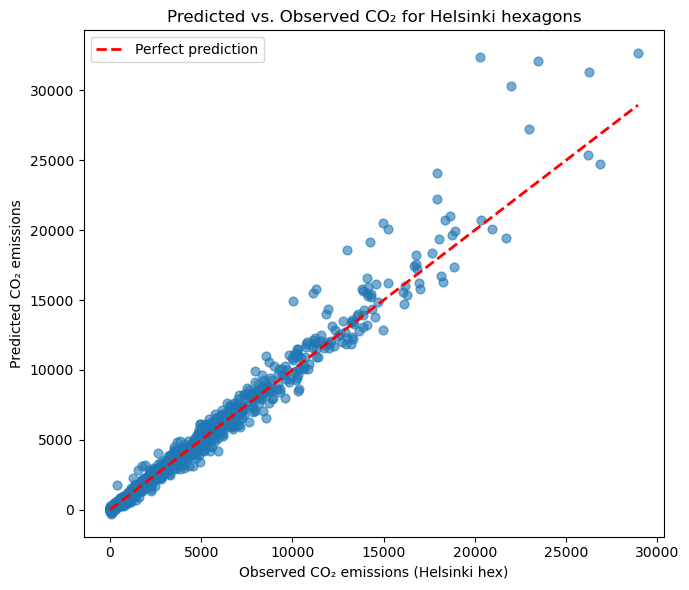

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results with 'true' and 'predicted' columns (adjust filenames/colnames as needed)
df = pd.read_csv('helsinki_hex_predicted_car_co2_tree.csv')  
# Make sure you have both:
#   - 'total_car_co2' (true/observed)
#   - 'predicted_car_co2' (model prediction)

if 'total_car_co2' not in df.columns:
    print("Warning: No observed CO₂ in file—cannot plot Predicted vs. Observed.")
else:
    plt.figure(figsize=(7,6))
    plt.scatter(df['total_car_co2'], df['predicted_car_co2'], alpha=0.6, s=40)
    plt.plot([df['total_car_co2'].min(), df['total_car_co2'].max()],
             [df['total_car_co2'].min(), df['total_car_co2'].max()],
             'r--', lw=2, label='Perfect prediction')
    plt.xlabel("Observed CO₂ emissions (Helsinki hex)")
    plt.ylabel("Predicted CO₂ emissions")
    plt.title("Predicted vs. Observed CO₂ for Helsinki hexagons")
    plt.legend()
    plt.tight_layout()
    plt.show()


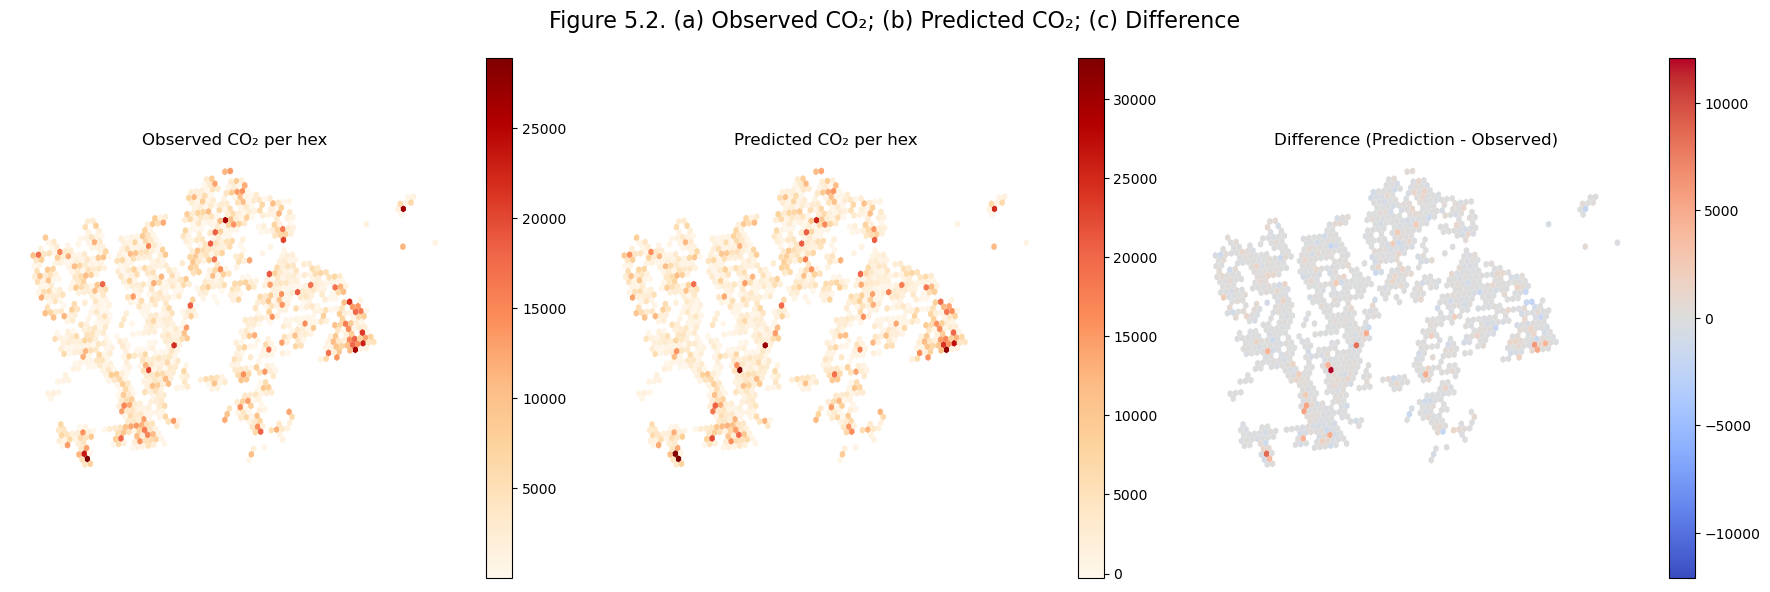

In [20]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load hex polygons and merge observed/predicted data
hexes = gpd.read_file('h3_polygons_Helsinki.gpkg')
hexes['hex_id'] = hexes['ID'].astype(str)  # adjust if needed

df = pd.read_csv('helsinki_hex_predicted_car_co2_tree.csv')  # make sure this has both observed and predicted columns

# Merge
merged = hexes.merge(df, on='hex_id', how='left')

# Compute difference
merged['diff'] = merged['predicted_car_co2'] - merged['total_car_co2']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
cmap = 'OrRd'

# (a) Observed
merged.plot(column='total_car_co2', ax=axs[0], cmap=cmap, legend=True)
axs[0].set_title('Observed CO₂ per hex')
axs[0].axis('off')

# (b) Predicted
merged.plot(column='predicted_car_co2', ax=axs[1], cmap=cmap, legend=True)
axs[1].set_title('Predicted CO₂ per hex')
axs[1].axis('off')

# (c) Difference
merged.plot(column='diff', ax=axs[2], cmap='coolwarm', legend=True, vmin=-abs(merged['diff']).max(), vmax=abs(merged['diff']).max())
axs[2].set_title('Difference (Prediction - Observed)')
axs[2].axis('off')

plt.suptitle('Figure 5.2. (a) Observed CO₂; (b) Predicted CO₂; (c) Difference', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


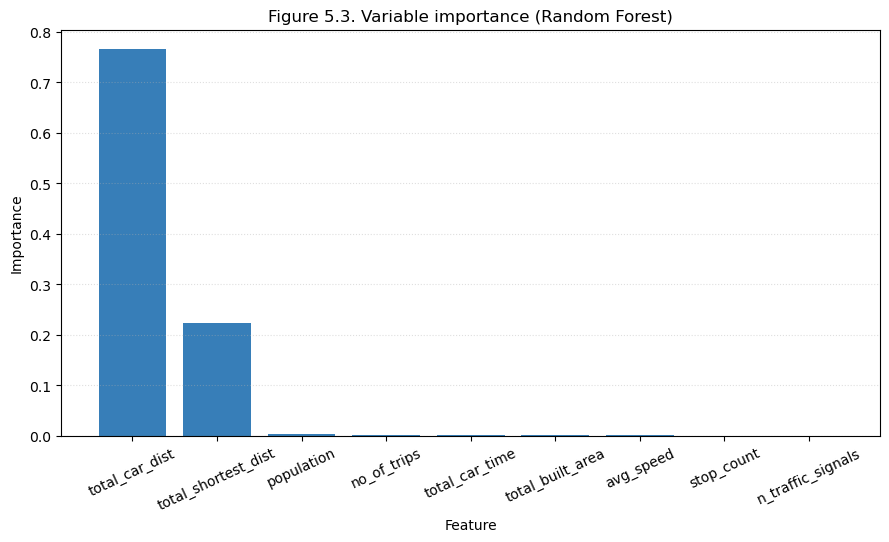

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# --- Paste your importances and features here ---
features = [
    "total_car_dist", "total_shortest_dist", "total_car_time", "avg_speed",
    "stop_count", "n_traffic_signals", "total_built_area", "no_of_trips", "population"
]
# Use Random Forest importances or permutation importances as needed
importances = [0.766, 0.223, 0.002, 0.001, 0.000, 0.000, 0.001, 0.002, 0.003]

# Sort for pretty plotting
idx = np.argsort(importances)[::-1]
features_sorted = [features[i] for i in idx]
importances_sorted = [importances[i] for i in idx]

plt.figure(figsize=(9,5))
plt.bar(features_sorted, importances_sorted, color="#377eb8")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Figure 5.3. Variable importance (Random Forest)")
plt.tight_layout()
plt.xticks(rotation=25)
plt.grid(axis='y', linestyle=':', alpha=0.4)
plt.show()
